In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

import seaborn as sns
from matplotlib import pyplot as plt
sns.set_theme(
    style="whitegrid",
    font_scale=2
);


In [2]:
DATA_FOLDER = Path('./data')
FRAME_LENGTH = 30
classes = [f.name for f in DATA_FOLDER.iterdir()]
classes

['running', 'stairs', 'walking', 'idle']

In [3]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(classes)

LabelEncoder()

In [381]:
x_acc_cols = [f'acc_x_{i}' for i in range(FRAME_LENGTH)]
y_acc_cols = [f'acc_y_{i}' for i in range(FRAME_LENGTH)]
z_acc_cols = [f'acc_z_{i}' for i in range(FRAME_LENGTH)]
m_acc_cols = [f'acc_m_{i}' for i in range(FRAME_LENGTH)]

In [260]:
frames = []
labels = []

for class_name in classes:
    class_folder = DATA_FOLDER / class_name
    for file in class_folder.iterdir():
        df = pd.read_csv(file)
        flat_frame = np.hstack([df['accelerometer_X'], df['accelerometer_Y'], df['accelerometer_Z']]).astype(float)
        frames.append(flat_frame)
        labels.append(class_name)

In [261]:
raw_data = pd.DataFrame(frames, columns = x_acc_cols+y_acc_cols+z_acc_cols)
raw_data = pd.concat([raw_data, pd.Series(labels, name='label')], axis=1)

In [262]:
raw_data.head(3)

acc_x_0   acc_x_1    acc_x_2    acc_x_3    acc_x_4   acc_x_5    acc_x_6  \
0   2.667141  4.017470  22.357056  17.922995  -2.164358  9.749189   3.303998   
1  10.745177  3.744532   0.766145  23.956383  -0.454898 -3.481169   3.572149   
2  22.031445  3.600880  -0.354342   8.245631  18.641254  4.381389  26.499025   

    acc_x_7    acc_x_8    acc_x_9  ...   acc_z_21  acc_z_22   acc_z_23  \
0 -3.275268   5.252879  21.490355  ...  13.493721 -2.001553  16.668432   
1  7.527370 -10.793061   9.481039  ...  11.468226 -0.952892  -0.943315   
2  4.003105   3.284845   2.231396  ...   0.565032 -4.079719  -3.677494   

   acc_z_24  acc_z_25   acc_z_26  acc_z_27  acc_z_28   acc_z_29    label  
0  9.208099 -7.187393  12.430696 -8.939949  1.470040  10.807426  running  
1 -0.416591  0.483629   0.363919  1.699883  3.390190  -1.407790  running  
2  4.596867 -0.550666  -6.019023 -1.139640 -2.164358  -3.016694  running  

[3 rows x 91 columns]

# Setup CV

In [263]:
raw_data.shape

(6462, 91)

In [264]:
raw_data.label.value_counts()

running    3408
walking    1850
idle       1039
stairs      165
Name: label, dtype: int64

In [265]:
from sklearn.model_selection import StratifiedKFold

In [266]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [267]:
X = raw_data['acc_x_0']
y = raw_data['label']

for i, (_, valid_ix) in enumerate(kfold.split(X, y)):
    y_valid = y.loc[valid_ix]
    value_counts = y_valid.value_counts()
    print(f'split#{i}, we have {value_counts.stairs} stairs, {value_counts.running} running samples')
#     print(    (y_valid == 'stairs').index)

split#0, we have 33 stairs, 682 running samples
split#1, we have 33 stairs, 682 running samples
split#2, we have 33 stairs, 682 running samples
split#3, we have 33 stairs, 681 running samples
split#4, we have 33 stairs, 681 running samples


In [268]:
from sklearn import svm
from sklearn.metrics import f1_score, confusion_matrix, multilabel_confusion_matrix

# 24 features

**A Study on Human Activity Recognition Using Accelerometer Data from Smartphones**

- mean_x, mean_y, mean_z
- MinMax_x, MinMax_y, MinMax_z
- std_x, std_y, std_z
- RMS_x, RMS_y, RMS_z
- corr_xy, corr_xz, corr_yz
- APF_x, APF_y, APF_z (average of peak frequency)
- VarAPF

## Am - magnitude of acceleration 

In [383]:
am_matrix = np.sqrt(raw_data[x_acc_cols].values**2 + raw_data[y_acc_cols].values**2 + raw_data[z_acc_cols].values**2)
raw_data = pd.concat([raw_data, pd.DataFrame(am_matrix, columns=m_acc_cols)], axis=1)

In [391]:
sample = raw_data.iloc[42]
assert np.allclose((sample.acc_x_0**2 + sample.acc_y_0**2 + sample.acc_z_0**2 ),  sample.acc_m_0**2)

In [269]:
feature_df = raw_data[['label']].copy()
feature_df['encoded_label'] = le.transform(feature_df['label'])

## mean 

In [392]:
def gen_feature_mean(ts):
    return np.mean(ts, axis=1)

In [395]:
feature_df['mean_x'] = gen_feature_mean(raw_data[x_acc_cols])
feature_df['mean_y'] = gen_feature_mean(raw_data[y_acc_cols])
feature_df['mean_z'] = gen_feature_mean(raw_data[z_acc_cols])
feature_df['mean_m'] = gen_feature_mean(raw_data[m_acc_cols])
mean_features = ['mean_x', 'mean_y', 'mean_z', 'mean_m']

In [1]:
# plt.rcParams['figure.figsize'] = [16,8]
# plt.rcParams['figure.dpi'] = 120 # 200 e.g. is really fine, but slower
sns.pairplot(data=feature_df[mean_features + ['label']], hue='label', height=5);

NameError: name 'sns' is not defined

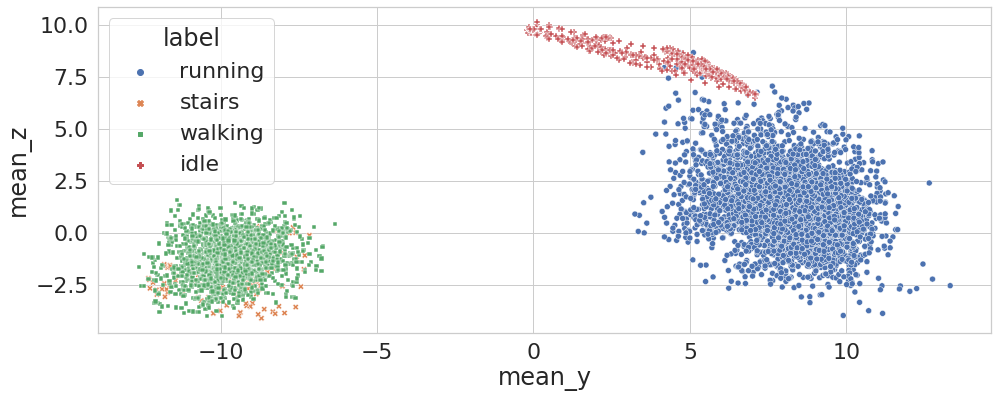

In [273]:
plt.figure(figsize=(16, 6))
sns.scatterplot(data=feature_df, x="mean_y", y="mean_z", hue="label", style="label")

In [397]:
X = feature_df[['mean_x', 'mean_y', 'mean_z']]
y = feature_df['label']
f_scores = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
#     print(valid_ix)
    cls = svm.SVC()
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    f_scores.append(f1_score(y_valid, y_pred, average=None).min())
#     print(confusion_matrix(y_valid, y_pred))
    
print(f'F1 score mean: {round(np.mean(f_scores), 2)}, std: {round(np.std(f_scores), 2)}')

F1 score mean: 0.06, std: 0.1


## minmax_range

In [398]:
def gen_feature_minmax_range(ts):
    return np.max(ts, axis=1) - np.min(ts, axis=1)


In [399]:
feature_df['minmax_range_x'] = gen_feature_minmax_range(raw_data[x_acc_cols])
feature_df['minmax_range_y'] = gen_feature_minmax_range(raw_data[y_acc_cols])
feature_df['minmax_range_z'] = gen_feature_minmax_range(raw_data[z_acc_cols])
feature_df['minmax_range_m'] = gen_feature_minmax_range(raw_data[m_acc_cols])
minmax_range_features = ['minmax_range_x', 'minmax_range_y', 'minmax_range_z', 'minmax_range_m']

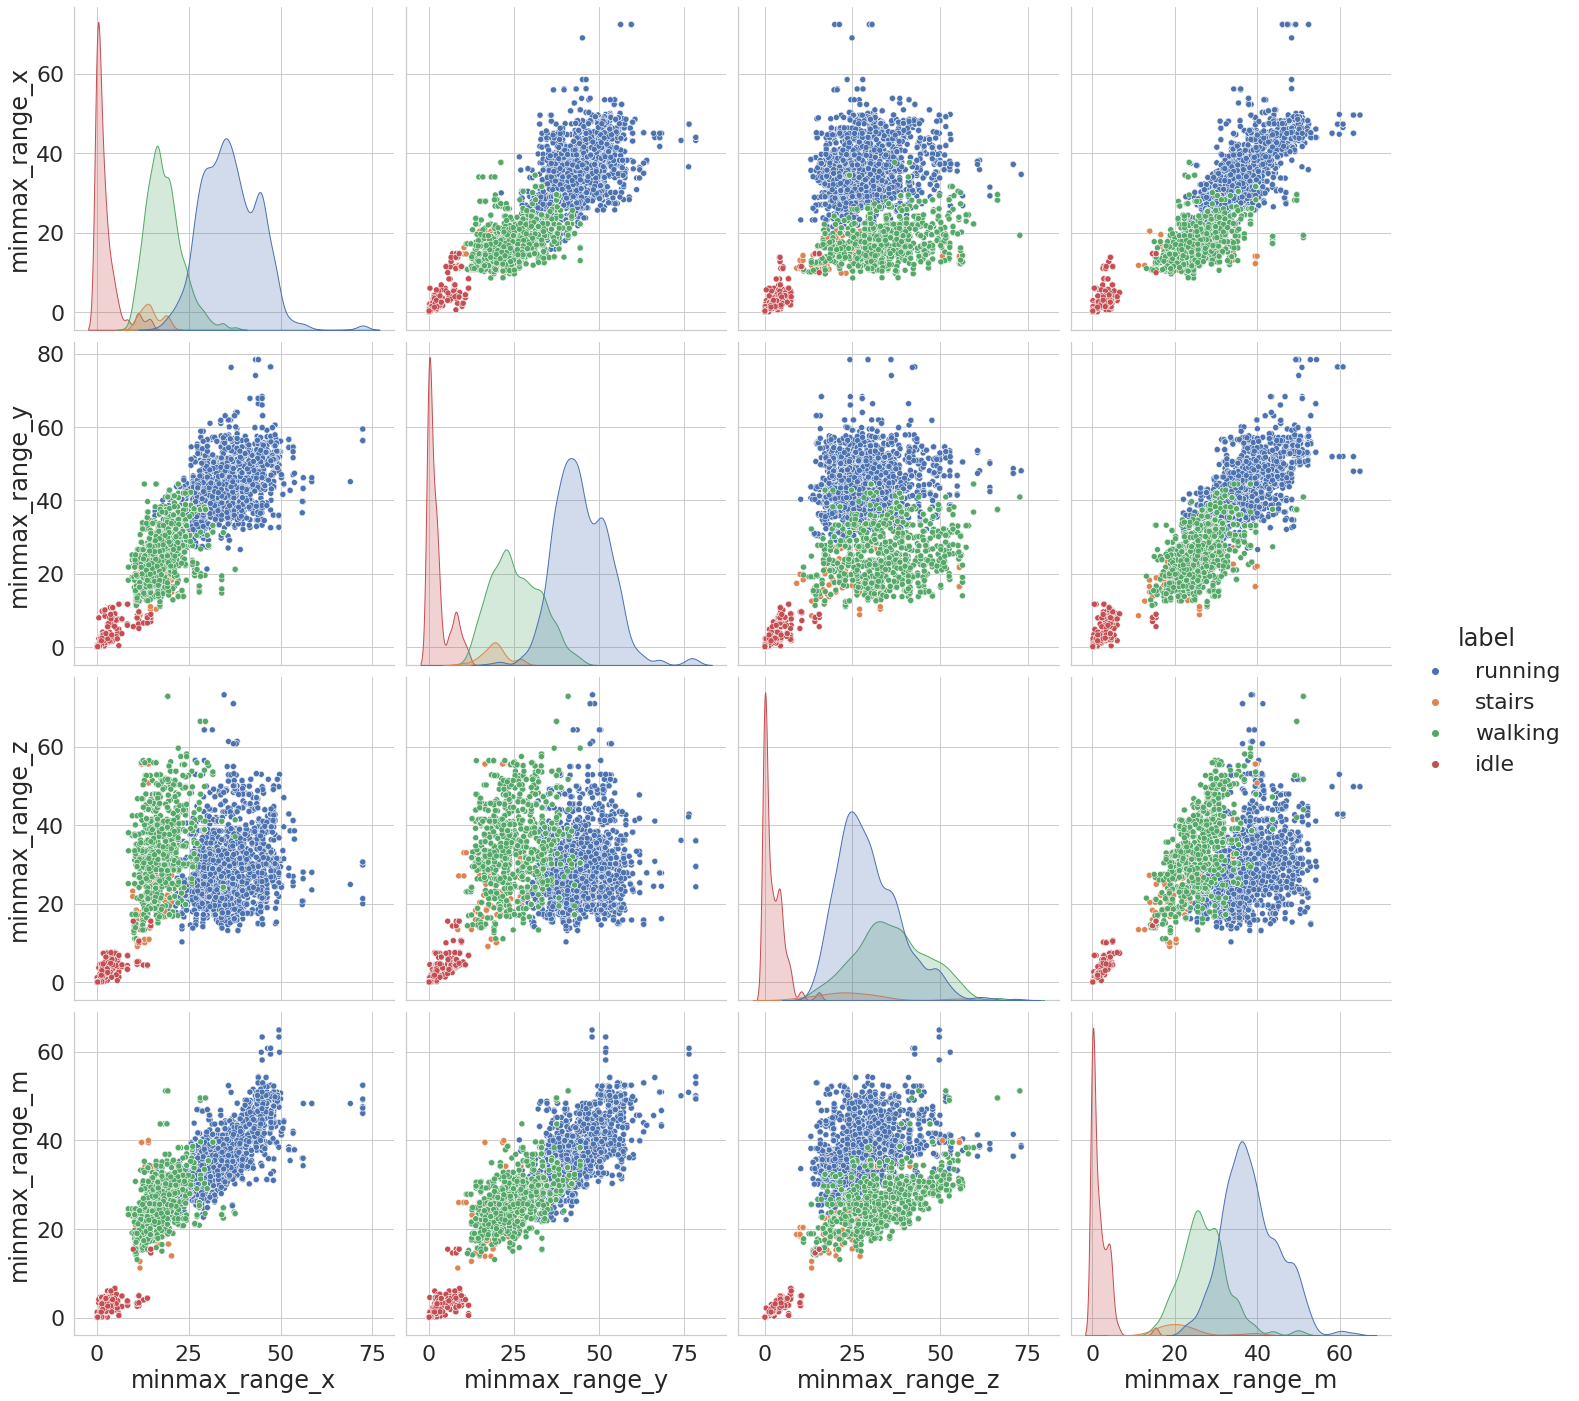

In [400]:
sns.pairplot(data=feature_df[minmax_range_features + ['label']], hue='label', height=5);

In [401]:
X = feature_df[['minmax_range_x', 'minmax_range_y', 'minmax_range_z']]
y = feature_df['label']
f_scores = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
#     print(valid_ix)
    cls = svm.SVC()
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    f_scores.append(f1_score(y_valid, y_pred, average=None).min())
    print(confusion_matrix(y_valid, y_pred))
    
print(f'F1 score mean: {round(np.mean(f_scores), 2)}, std: {round(np.std(f_scores), 2)}')

[[208   0   0   0]
 [  0 667   0  15]
 [  1   0   0  32]
 [  0  14   0 356]]
[[208   0   0   0]
 [  0 670   0  12]
 [  0   0   0  33]
 [  1  11   0 358]]
[[207   0   0   0]
 [  0 671   0  11]
 [  0   0   0  33]
 [  0  23   0 347]]
[[208   0   0   0]
 [  0 670   0  11]
 [  0   0   0  33]
 [  0  17   0 353]]
[[208   0   0   0]
 [  0 669   0  12]
 [  0   0   0  33]
 [  1  17   0 352]]
F1 score mean: 0.0, std: 0.0


In [403]:
X = feature_df[mean_features + minmax_range_features]
y = feature_df['label']
f_scores = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
#     print(valid_ix)
    cls = svm.SVC()
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    f_scores.append(f1_score(y_valid, y_pred, average=None).min())
    print(confusion_matrix(y_valid, y_pred))
    
print(f'F1 score mean: {round(np.mean(f_scores), 2)}, std: {round(np.std(f_scores), 2)}')

[[208   0   0   0]
 [  0 682   0   0]
 [  0   0   0  33]
 [  0   0   0 370]]
[[208   0   0   0]
 [  0 682   0   0]
 [  0   0   0  33]
 [  0   0   0 370]]
[[207   0   0   0]
 [  0 682   0   0]
 [  0   0   0  33]
 [  0   0   0 370]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0   0  33]
 [  0   0   0 370]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0   0  33]
 [  0   0   0 370]]
F1 score mean: 0.0, std: 0.0


In [280]:
from sklearn.linear_model import LogisticRegression

In [405]:
X = feature_df[mean_features + minmax_range_features]
y = feature_df['label']
f_scores = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
#     print(valid_ix)
    cls = LogisticRegression(max_iter=3_000)
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    f_scores.append(f1_score(y_valid, y_pred, average=None).min())
    print(confusion_matrix(y_valid, y_pred))
    
print(f'F1 score mean: {round(np.mean(f_scores), 2)}, std: {round(np.std(f_scores), 2)}')

[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  19  14]
 [  0   0   3 367]]
[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  24   9]
 [  0   0  11 359]]
[[207   0   0   0]
 [  0 682   0   0]
 [  0   0  23  10]
 [  0   0   3 367]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  19  14]
 [  0   0   7 363]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  25   8]
 [  0   0   5 365]]
F1 score mean: 0.72, std: 0.06


# Go to binary classification

In [406]:
raw_stairs_df = raw_data[raw_data['label'].isin(['stairs', 'walking'])].copy().reset_index(drop=True)
raw_stairs_df.head(2)

acc_x_0   acc_x_1   acc_x_2   acc_x_3   acc_x_4   acc_x_5   acc_x_6  \
0  0.675165 -1.278504 -4.424484  0.646435 -1.623269 -4.323928 -5.228936   
1  2.264915  0.991200  2.226608 -1.647211  8.398860  2.494758  0.823605   

    acc_x_7   acc_x_8    acc_x_9  ...   acc_m_20   acc_m_21   acc_m_22  \
0 -3.088520 -3.021482 -11.238382  ...  14.010827  22.597199  14.597832   
1 -6.224924  1.273715   0.723049  ...   4.342221   6.940678   8.543656   

    acc_m_23  acc_m_24  acc_m_25  acc_m_26   acc_m_27   acc_m_28  acc_m_29  
0   3.849918  8.267060  6.248105  9.497119  14.720401  11.890416  8.611713  
1  10.177108  9.888059  7.962330  9.761773   6.102111   9.302489  5.768746  

[2 rows x 121 columns]

In [407]:
stairs_df = feature_df[feature_df['label'].isin(['stairs', 'walking'])].copy().reset_index(drop=True)
stairs_df.head()

label  encoded_label    mean_x     mean_y    mean_z  minmax_range_x  \
0  stairs              2 -3.484042  -8.297824 -0.513955       15.207968   
1  stairs              2  0.457133  -8.333099 -3.764004       14.623784   
2  stairs              2  2.487257 -11.696792 -1.645455       14.058752   
3  stairs              2  1.993732  -8.358956 -0.573491       20.350714   
4  stairs              2 -0.800940 -11.220506 -2.930503       18.564640   

   minmax_range_y  minmax_range_z     mean_m  minmax_range_m  
0       19.924546       22.773646  10.572338       21.208216  
1       10.390835       33.006464  10.173855       25.964769  
2       21.763294       55.578997  14.590656       39.408099  
3       16.558300       27.255591  11.530563       13.844787  
4       26.891676       26.580427  13.321213       24.829162

In [408]:
stairs_df['is_stairs'] = stairs_df['label'] == 'stairs'

In [409]:
X = stairs_df[mean_features + minmax_range_features]
y = stairs_df['is_stairs']
f_scores = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
#     print(valid_ix)
    cls = LogisticRegression(max_iter=2_000)
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
#     f_scores.append(f1_score(y_valid, y_pred, average=None).min())
    f_scores.append(f1_score(y_valid, y_pred))
    print(confusion_matrix(y_valid, y_pred))
    
print(f'F1 score mean: {round(np.mean(f_scores), 2)}, std: {round(np.std(f_scores), 2)}')

[[362   8]
 [  8  25]]
[[365   5]
 [  8  25]]
[[364   6]
 [ 13  20]]
[[369   1]
 [ 15  18]]
[[364   6]
 [ 13  20]]
F1 score mean: 0.72, std: 0.05


In [410]:
X = stairs_df[mean_features + minmax_range_features]
y = stairs_df['is_stairs']
f_scores = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
#     print(valid_ix)
    cls = svm.SVC()
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
#     f_scores.append(f1_score(y_valid, y_pred, average=None).min())
    f_scores.append(f1_score(y_valid, y_pred))
    print(confusion_matrix(y_valid, y_pred))
    
print(f'F1 score mean: {round(np.mean(f_scores), 2)}, std: {round(np.std(f_scores), 2)}')

[[370   0]
 [ 32   1]]
[[370   0]
 [ 33   0]]
[[370   0]
 [ 32   1]]
[[370   0]
 [ 33   0]]
[[370   0]
 [ 33   0]]
F1 score mean: 0.02, std: 0.03


## std

In [288]:
def gen_feature_std(ts):
    return np.std(ts, axis=1)

In [411]:
stairs_df['std_x'] = gen_feature_std(raw_stairs_df[x_acc_cols])
stairs_df['std_y'] = gen_feature_std(raw_stairs_df[y_acc_cols])
stairs_df['std_z'] = gen_feature_std(raw_stairs_df[z_acc_cols])
stairs_df['std_m'] = gen_feature_std(raw_stairs_df[m_acc_cols])

In [412]:
std_features = ['std_x', 'std_y', 'std_z', 'std_m']

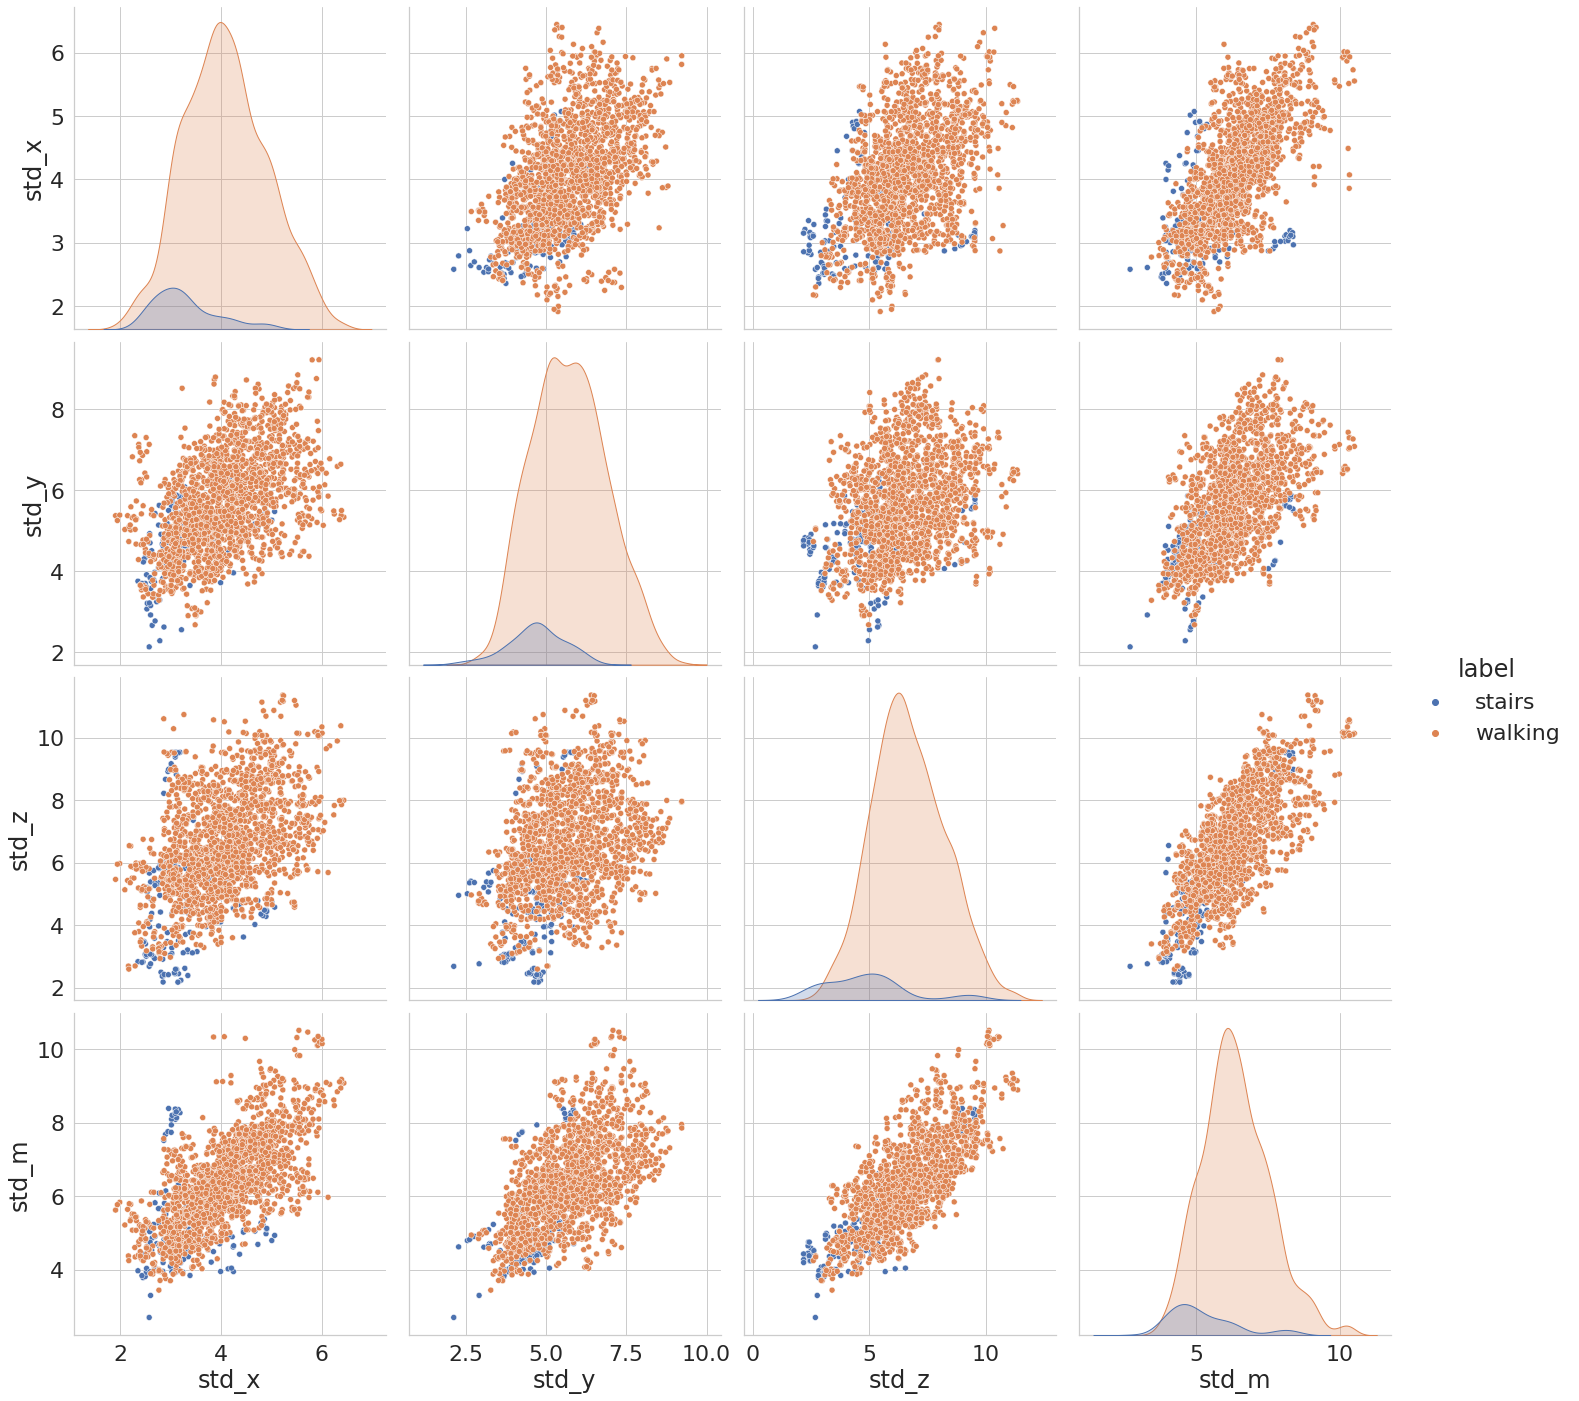

In [413]:
# plt.rcParams['figure.figsize'] = [16,8]
# plt.rcParams['figure.dpi'] = 120 # 200 e.g. is really fine, but slower
sns.pairplot(data=stairs_df[std_features + ['label']], hue='label', height=5);

In [292]:
X = stairs_df[mean_features + minmax_range_features + std_features]
y = stairs_df['is_stairs']
f_scores = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
#     print(valid_ix)
    cls = LogisticRegression(max_iter=2_000)
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
#     f_scores.append(f1_score(y_valid, y_pred, average=None).min())
    f_scores.append(f1_score(y_valid, y_pred))
    print(confusion_matrix(y_valid, y_pred))
    
print(f'F1 score mean: {round(np.mean(f_scores), 2)}, std: {round(np.std(f_scores), 2)}')

[[360  10]
 [  8  25]]
[[365   5]
 [  8  25]]
[[364   6]
 [ 13  20]]
[[367   3]
 [ 16  17]]
[[364   6]
 [ 12  21]]
F1 score mean: 0.71, std: 0.05


In [414]:
X = stairs_df[mean_features + minmax_range_features + std_features]
y = stairs_df['is_stairs']
f_scores = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
#     print(valid_ix)
    cls = LogisticRegression(max_iter=2_000)
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
#     f_scores.append(f1_score(y_valid, y_pred, average=None).min())
    f_scores.append(f1_score(y_valid, y_pred))
    print(confusion_matrix(y_valid, y_pred))
    
print(f'F1 score mean: {round(np.mean(f_scores), 2)}, std: {round(np.std(f_scores), 2)}')

[[362   8]
 [  7  26]]
[[365   5]
 [  7  26]]
[[365   5]
 [ 12  21]]
[[368   2]
 [ 14  19]]
[[364   6]
 [ 11  22]]
F1 score mean: 0.75, std: 0.04


## RMS

In [293]:
def gen_feature_rms(ts):
    return np.sqrt(np.mean(np.square(ts), axis=1))

In [415]:
stairs_df['rms_x'] = gen_feature_rms(raw_stairs_df[x_acc_cols])
stairs_df['rms_y'] = gen_feature_rms(raw_stairs_df[y_acc_cols])
stairs_df['rms_z'] = gen_feature_rms(raw_stairs_df[z_acc_cols])
stairs_df['rms_m'] = gen_feature_rms(raw_stairs_df[m_acc_cols])

rms_features = ['rms_x', 'rms_y', 'rms_z', 'rms_m']

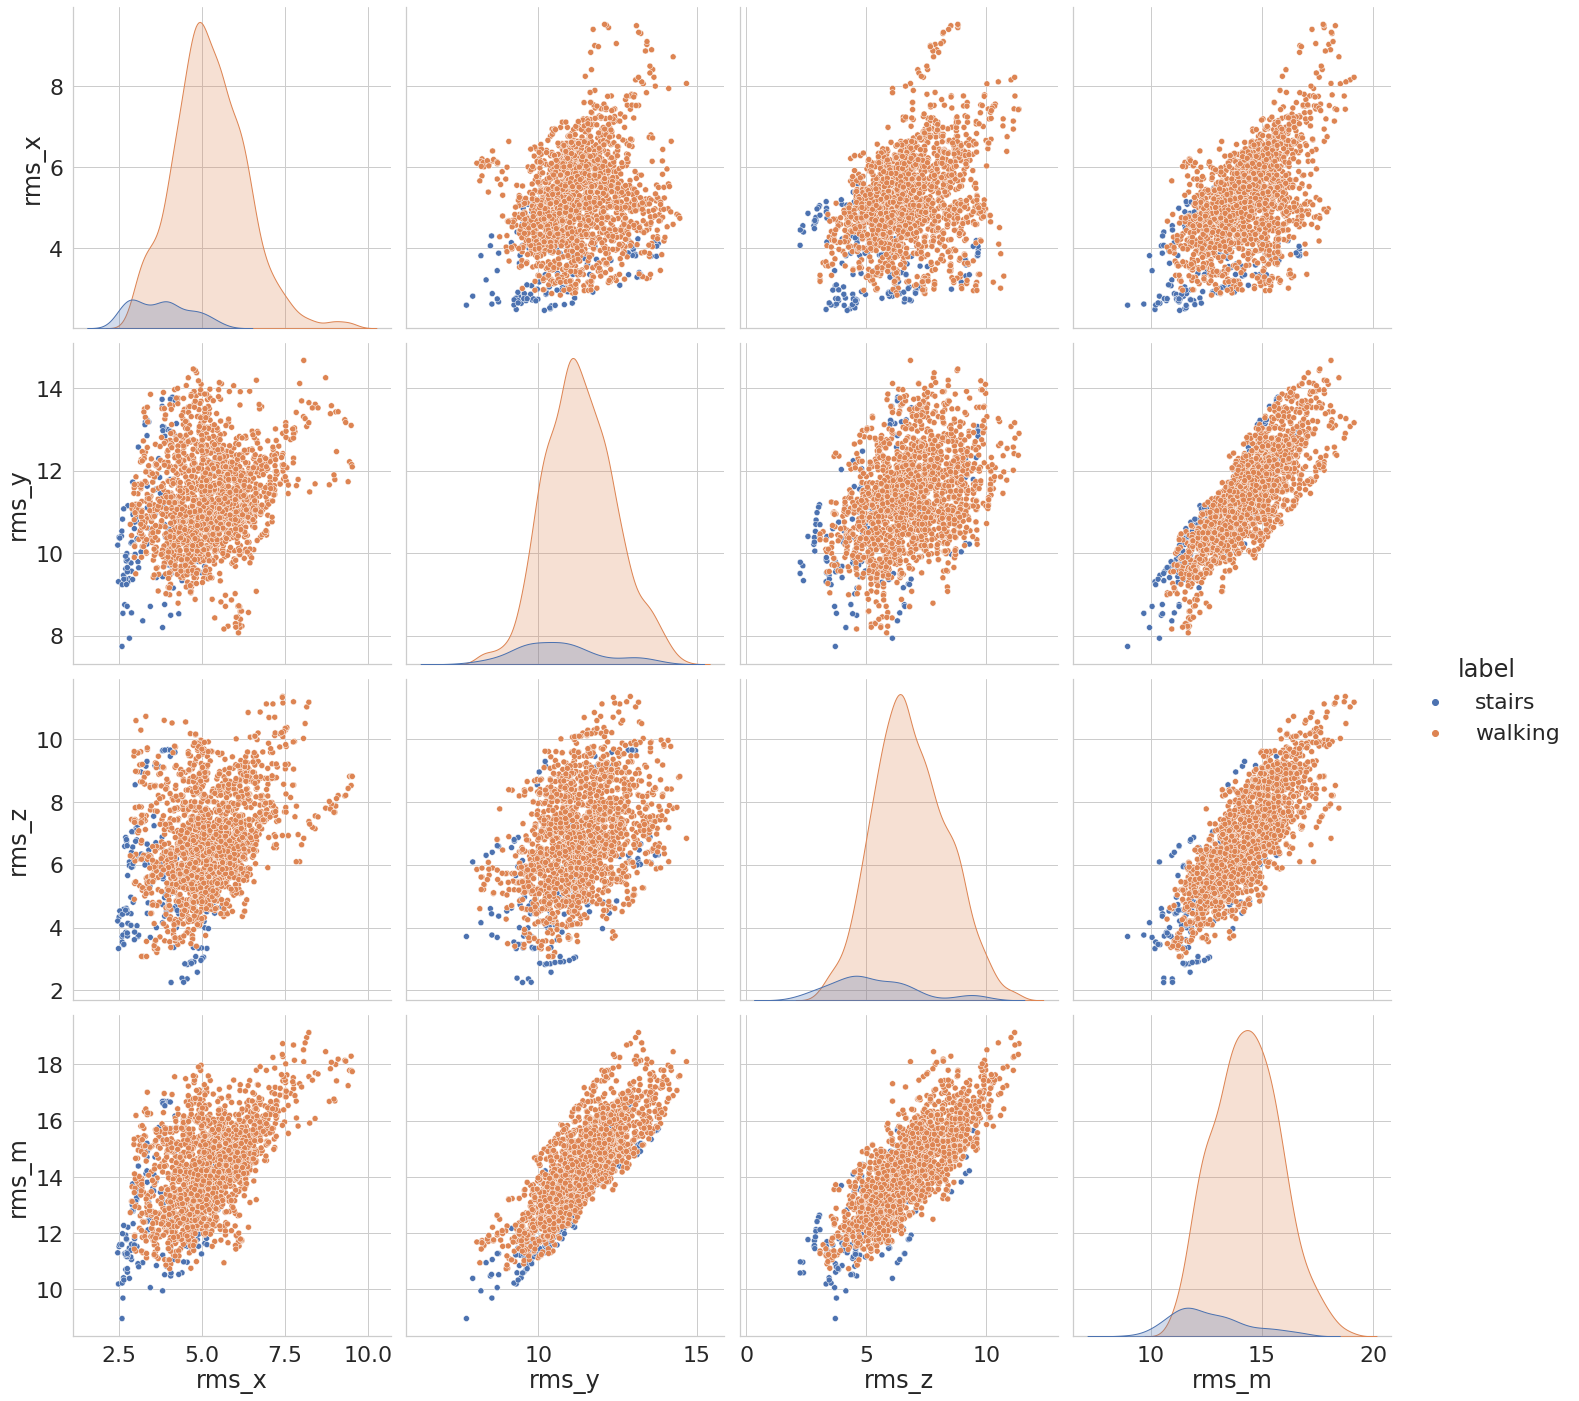

In [416]:
# plt.rcParams['figure.figsize'] = [16,8]
# plt.rcParams['figure.dpi'] = 120 # 200 e.g. is really fine, but slower
sns.pairplot(data=stairs_df[rms_features + ['label']], hue='label', height=5);

In [296]:
X = stairs_df[mean_features + minmax_range_features + std_features + rms_features]
y = stairs_df['is_stairs']
f_scores = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
#     print(valid_ix)
    cls = LogisticRegression(max_iter=2_000)
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
#     f_scores.append(f1_score(y_valid, y_pred, average=None).min())
    f_scores.append(f1_score(y_valid, y_pred))
    print(confusion_matrix(y_valid, y_pred))
    
print(f'F1 score mean: {round(np.mean(f_scores), 2)}, std: {round(np.std(f_scores), 2)}')

[[360  10]
 [  9  24]]
[[363   7]
 [  8  25]]
[[364   6]
 [ 12  21]]
[[366   4]
 [ 14  19]]
[[364   6]
 [ 13  20]]
F1 score mean: 0.71, std: 0.03


In [417]:
X = stairs_df[mean_features + minmax_range_features + std_features + rms_features]
y = stairs_df['is_stairs']
f_scores = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
#     print(valid_ix)
    cls = LogisticRegression(max_iter=2_000)
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
#     f_scores.append(f1_score(y_valid, y_pred, average=None).min())
    f_scores.append(f1_score(y_valid, y_pred))
    print(confusion_matrix(y_valid, y_pred))
    
print(f'F1 score mean: {round(np.mean(f_scores), 2)}, std: {round(np.std(f_scores), 2)}')

[[361   9]
 [  7  26]]
[[366   4]
 [  7  26]]
[[365   5]
 [ 12  21]]
[[366   4]
 [ 14  19]]
[[365   5]
 [ 11  22]]
F1 score mean: 0.74, std: 0.05


In [297]:
(y_valid != y_pred).sum()

19

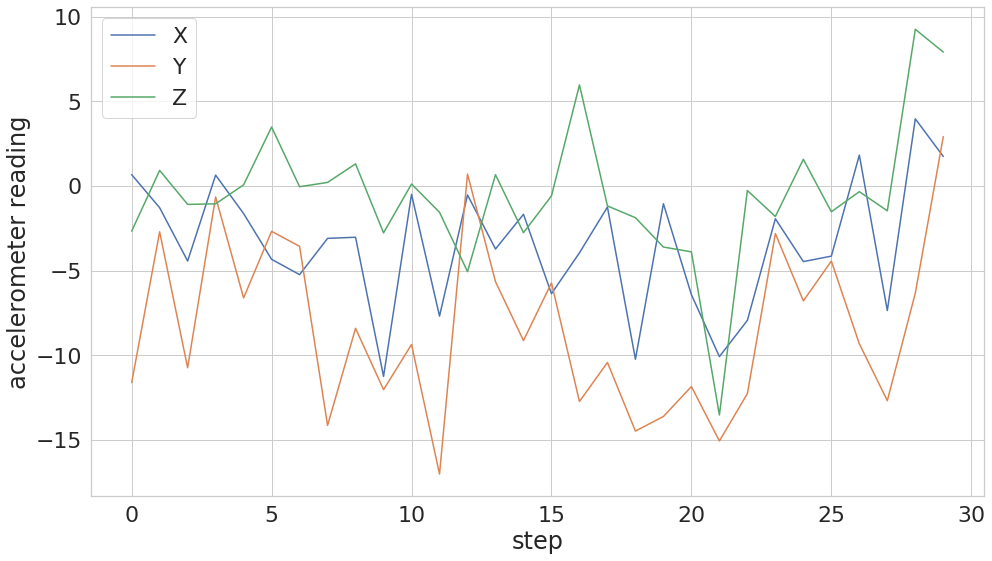

In [298]:
frame = raw_stairs_df.loc[0]
def plot_frame(frame, title=None):
    plt.figure(figsize=(16,9))
    sns.lineplot(y=frame[x_acc_cols].astype(float), x=np.arange(30), label='X')
    sns.lineplot(y=frame[y_acc_cols].astype(float), x=np.arange(30), label='Y')
    sns.lineplot(y=frame[z_acc_cols].astype(float), x=np.arange(30), label='Z').set_title(title)
    plt.ylabel('accelerometer reading')
    plt.xlabel('step')
    
plot_frame(frame)

In [299]:
misclassified_ix = y_valid[y_valid != y_pred].index
misclassified_ix, misclassified_ix.shape

(Int64Index([   2,    4,   17,   36,   90,  108,  117,  128,  143,  149,  150,
              158,  163,  213,  273,  793,  859, 1397, 1574],
            dtype='int64'),
 (19,))

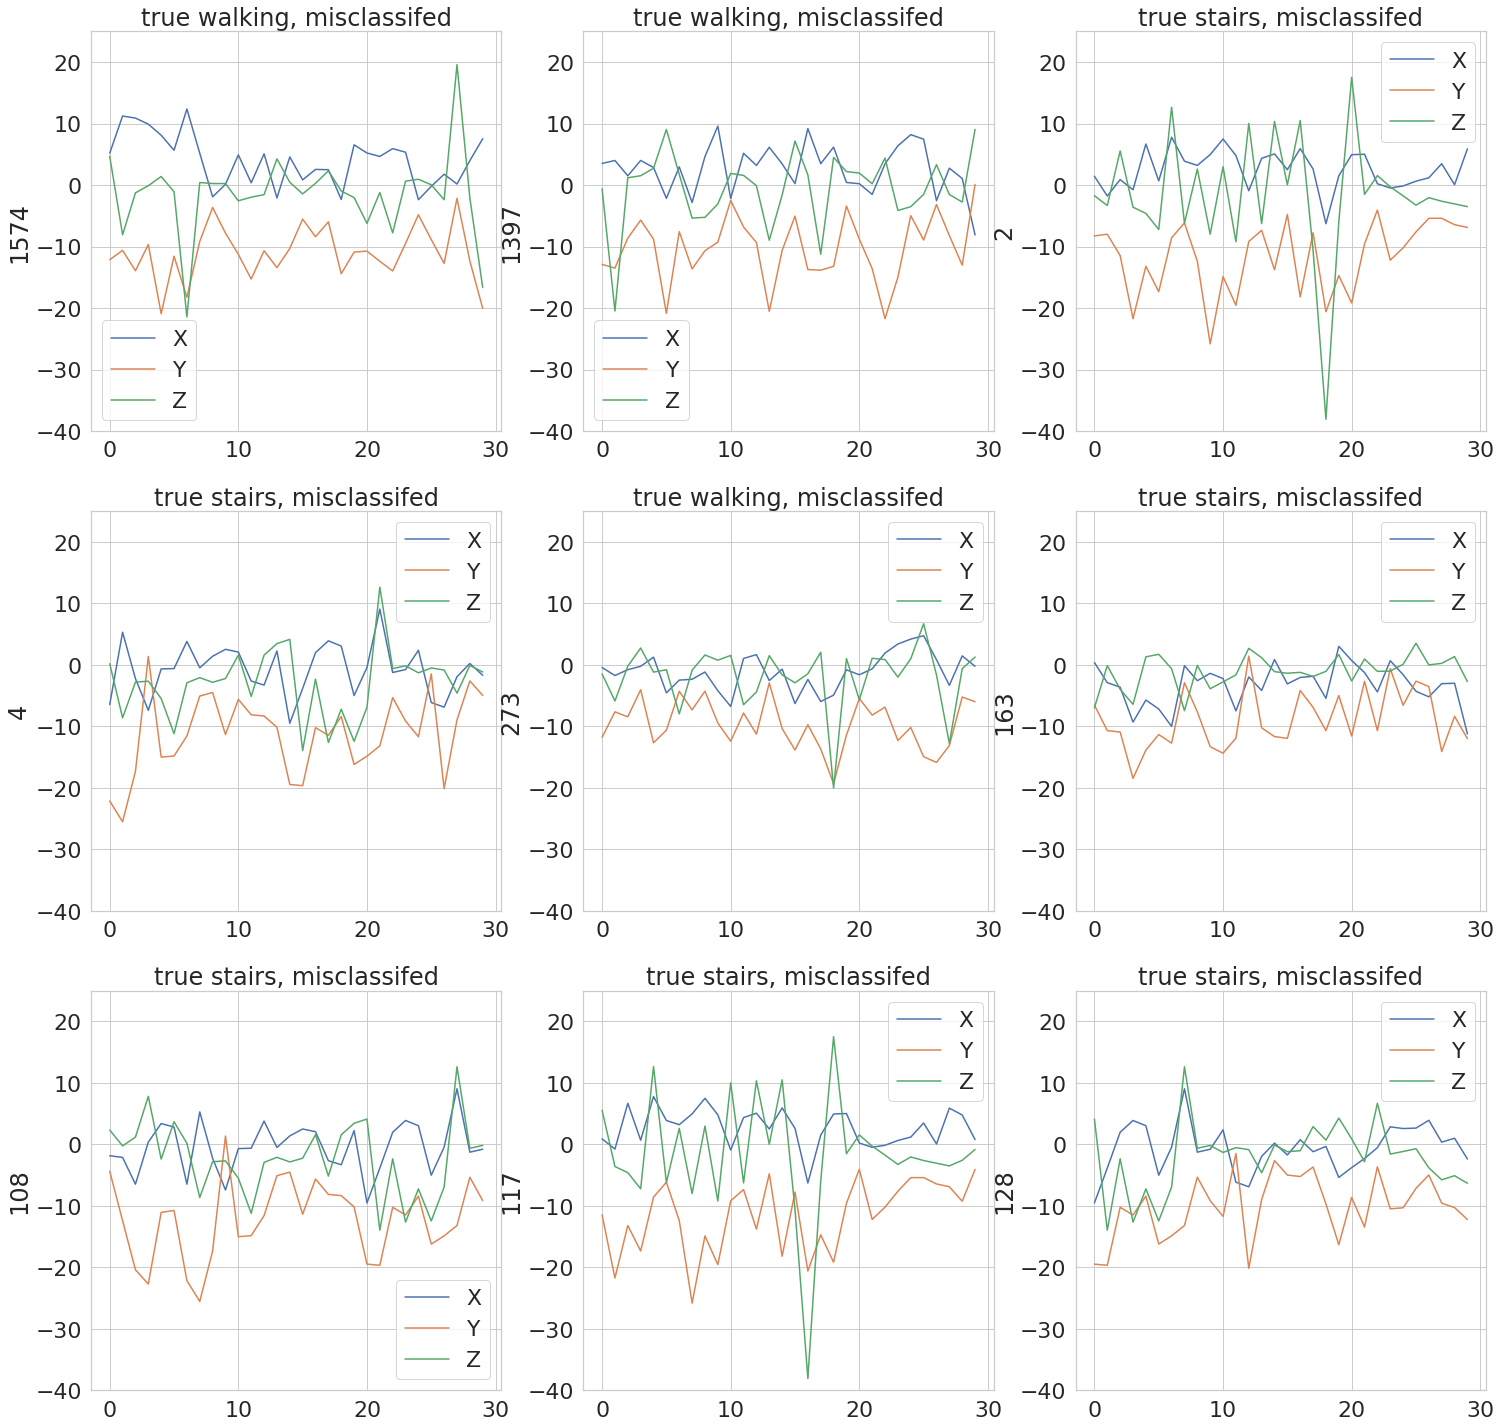

In [300]:
fig, axes = plt.subplots(3, 3, figsize=(25, 25))
axes = axes.flatten()

np.random.seed(1)
# misclassified_sample_ix = np.random.choice(misclassified_ix, size=9)
misclassified_sample_ix = np.array([1574, 1397, 2, 4, 273,163, 108,  117,  128,  143,  149,  150,])
for i, ax in enumerate(axes):
    frame = raw_stairs_df.loc[misclassified_sample_ix[i]]
    sns.lineplot(y=frame[x_acc_cols].astype(float), x=np.arange(30), label='X', ax=ax)
    sns.lineplot(y=frame[y_acc_cols].astype(float), x=np.arange(30), label='Y', ax=ax)
    sns.lineplot(y=frame[z_acc_cols].astype(float), x=np.arange(30), label='Z', ax=ax).set_title(f'true {frame.label}, misclassifed')
    ax.set_ylim(-40, 25)
# plt.ylim(-40, 25)

## corr

In [304]:
obs

acc_x_0     0.675165
acc_x_1      -1.2785
acc_x_2     -4.42448
acc_x_3     0.646435
acc_x_4     -1.62327
              ...   
acc_z_26     -0.3304
acc_z_27    -1.46046
acc_z_28     9.25598
acc_z_29     7.91044
label         stairs
Name: 0, Length: 91, dtype: object

In [418]:
np.correlate

<function numpy.correlate(a, v, mode='valid')>

In [419]:
obs = raw_stairs_df.iloc[0]


In [420]:
stairs_df['corr_xy'] = None

In [421]:
corr_matrix_xy = np.corrcoef(raw_stairs_df[x_acc_cols].astype('float64'), raw_stairs_df[y_acc_cols].astype('float64'))
corr_matrix_yz = np.corrcoef(raw_stairs_df[z_acc_cols].astype('float64'), raw_stairs_df[y_acc_cols].astype('float64'))
corr_matrix_xz = np.corrcoef(raw_stairs_df[x_acc_cols].astype('float64'), raw_stairs_df[z_acc_cols].astype('float64'))

In [422]:
ix = np.arange(len(stairs_df))
iy = ix + len(stairs_df)

In [423]:
stairs_df['corr_xy'] = corr_matrix_xy[ix, iy]
stairs_df['corr_yz'] = corr_matrix_yz[ix, iy]
stairs_df['corr_xz'] = corr_matrix_xz[ix, iy]

In [424]:
stairs_df['corr_xy']

0       0.518031
1      -0.455448
2      -0.026224
3       0.313036
4       0.037058
          ...   
2010    0.357598
2011    0.309853
2012   -0.094162
2013   -0.294859
2014    0.220485
Name: corr_xy, Length: 2015, dtype: float64

In [425]:
stairs_df['corr_xy'][42]

-0.13812277567617734

In [426]:
np.corrcoef(raw_stairs_df.iloc[0][x_acc_cols].astype('float64'), raw_stairs_df.iloc[0][y_acc_cols].astype('float64'))[0, 1], np.corrcoef(raw_stairs_df.iloc[42][x_acc_cols].astype('float64'), raw_stairs_df.iloc[42][y_acc_cols].astype('float64'))[0, 1]

(0.5180305700579393, -0.13812277567617734)

In [427]:
corr_features = ['corr_xy', 'corr_yz', 'corr_xz']

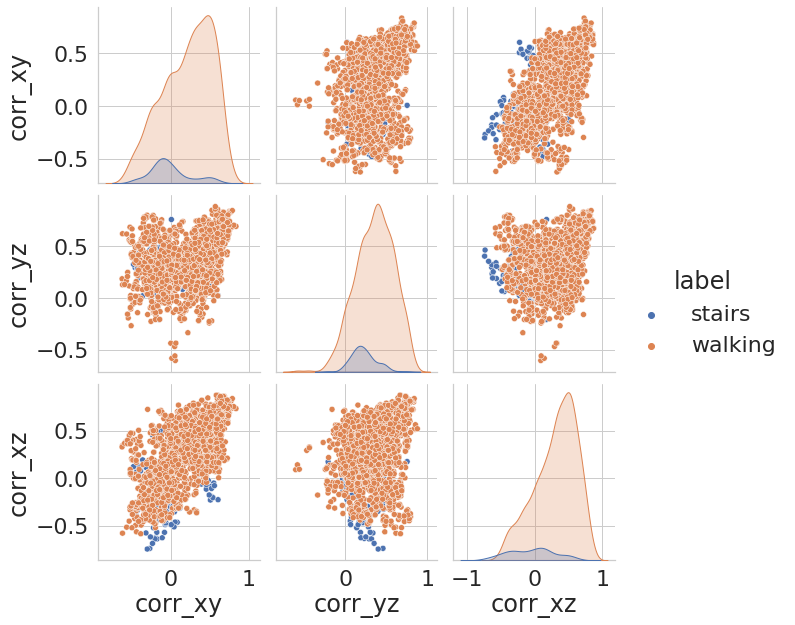

In [428]:
sns.pairplot(data=stairs_df[corr_features + ['label']], hue='label', height=3);

In [329]:
X = stairs_df[mean_features + minmax_range_features + std_features + rms_features + corr_features]
y = stairs_df['is_stairs']
f_scores = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
#     print(valid_ix)
    cls = LogisticRegression(max_iter=2_000)
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
#     f_scores.append(f1_score(y_valid, y_pred, average=None).min())
    f_scores.append(f1_score(y_valid, y_pred))
    print(confusion_matrix(y_valid, y_pred))
    
print(f'F1 score mean: {round(np.mean(f_scores), 2)}, std: {round(np.std(f_scores), 2)}')

[[366   4]
 [  6  27]]
[[366   4]
 [  8  25]]
[[366   4]
 [ 11  22]]
[[369   1]
 [ 10  23]]
[[365   5]
 [  8  25]]
F1 score mean: 0.8, std: 0.03


In [333]:
from sklearn.ensemble import RandomForestClassifier

In [431]:
X = stairs_df[mean_features + minmax_range_features + std_features + rms_features + corr_features]
y = stairs_df['is_stairs']
f_scores = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
#     print(valid_ix)
    cls = RandomForestClassifier()
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
#     f_scores.append(f1_score(y_valid, y_pred, average=None).min())
    f_scores.append(f1_score(y_valid, y_pred))
    print(confusion_matrix(y_valid, y_pred))
    
print(f'F1 score mean: {round(np.mean(f_scores), 2)}, std: {round(np.std(f_scores), 2)}')

[[370   0]
 [  2  31]]
[[370   0]
 [  2  31]]
[[370   0]
 [  3  30]]
[[370   0]
 [  3  30]]
[[370   0]
 [  3  30]]
F1 score mean: 0.96, std: 0.01


In [432]:
misclassified_ix = y_valid[y_valid != y_pred].index
misclassified_ix, misclassified_ix.shape

(Int64Index([4, 149, 161], dtype='int64'), (3,))

In [437]:
y_valid[(y_valid == y_pred) & ~y_valid]

170     False
178     False
183     False
184     False
185     False
        ...  
1992    False
2008    False
2011    False
2012    False
2014    False
Name: is_stairs, Length: 370, dtype: bool

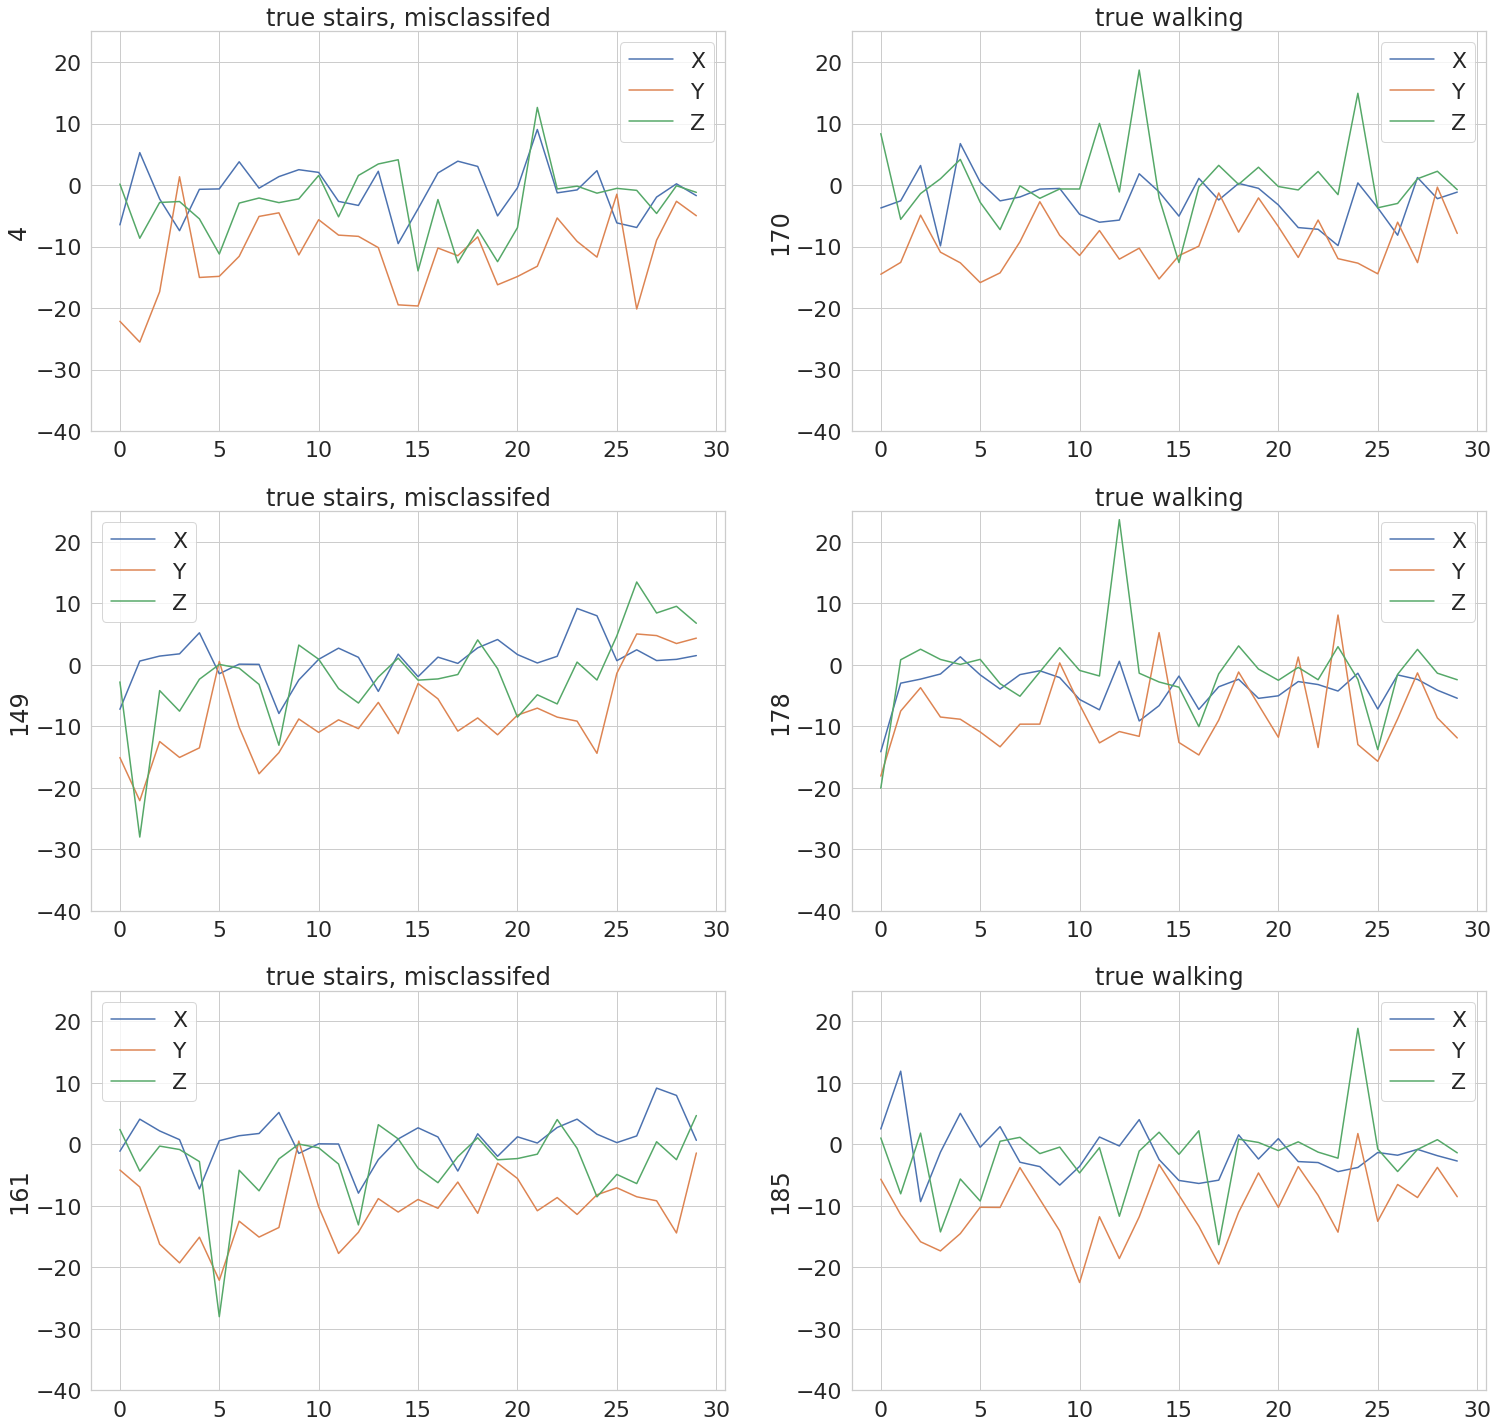

In [441]:
fig, axes = plt.subplots(3, 2, figsize=(25, 25))

for i, ax in enumerate(axes[:, 0]):
    frame = raw_stairs_df.loc[misclassified_ix[i]]
    sns.lineplot(y=frame[x_acc_cols].astype(float), x=np.arange(30), label='X', ax=ax)
    sns.lineplot(y=frame[y_acc_cols].astype(float), x=np.arange(30), label='Y', ax=ax)
    sns.lineplot(y=frame[z_acc_cols].astype(float), x=np.arange(30), label='Z', ax=ax).set_title(f'true {frame.label}, misclassifed')
    ax.set_ylim(-40, 25)
    
true_walking_sample = [170, 178, 185]
for i, ax in enumerate(axes[:, 1]):
    frame = raw_stairs_df.loc[true_walking_sample[i]]
    sns.lineplot(y=frame[x_acc_cols].astype(float), x=np.arange(30), label='X', ax=ax)
    sns.lineplot(y=frame[y_acc_cols].astype(float), x=np.arange(30), label='Y', ax=ax)
    sns.lineplot(y=frame[z_acc_cols].astype(float), x=np.arange(30), label='Z', ax=ax).set_title(f'true {frame.label}')
    ax.set_ylim(-40, 25)

In [456]:
def gen_feature_min(ts):
    return np.min(ts, axis=1)

In [457]:
stairs_df['min_x'] = gen_feature_min(raw_stairs_df[x_acc_cols])
stairs_df['min_y'] = gen_feature_min(raw_stairs_df[y_acc_cols])
stairs_df['min_z'] = gen_feature_min(raw_stairs_df[z_acc_cols])
stairs_df['min_m'] = gen_feature_min(raw_stairs_df[m_acc_cols])
min_features = ['min_x', 'min_y', 'min_z', 'min_m']

In [459]:
X = stairs_df[mean_features + minmax_range_features + std_features + rms_features + corr_features + min_features]
y = stairs_df['is_stairs']
f_scores = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
#     print(valid_ix)
    cls = RandomForestClassifier()
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
#     f_scores.append(f1_score(y_valid, y_pred, average=None).min())
    f_scores.append(f1_score(y_valid, y_pred))
    print(confusion_matrix(y_valid, y_pred))
    print(y_valid[y_valid != y_pred].index)
    
print(f'F1 score mean: {round(np.mean(f_scores), 2)}, std: {round(np.std(f_scores), 2)}')

[[370   0]
 [  2  31]]
Int64Index([29, 99], dtype='int64')
[[370   0]
 [  1  32]]
Int64Index([0], dtype='int64')
[[370   0]
 [  1  32]]
Int64Index([78], dtype='int64')
[[370   0]
 [  2  31]]
Int64Index([15, 89], dtype='int64')
[[370   0]
 [  2  31]]
Int64Index([4, 149], dtype='int64')
F1 score mean: 0.98, std: 0.01


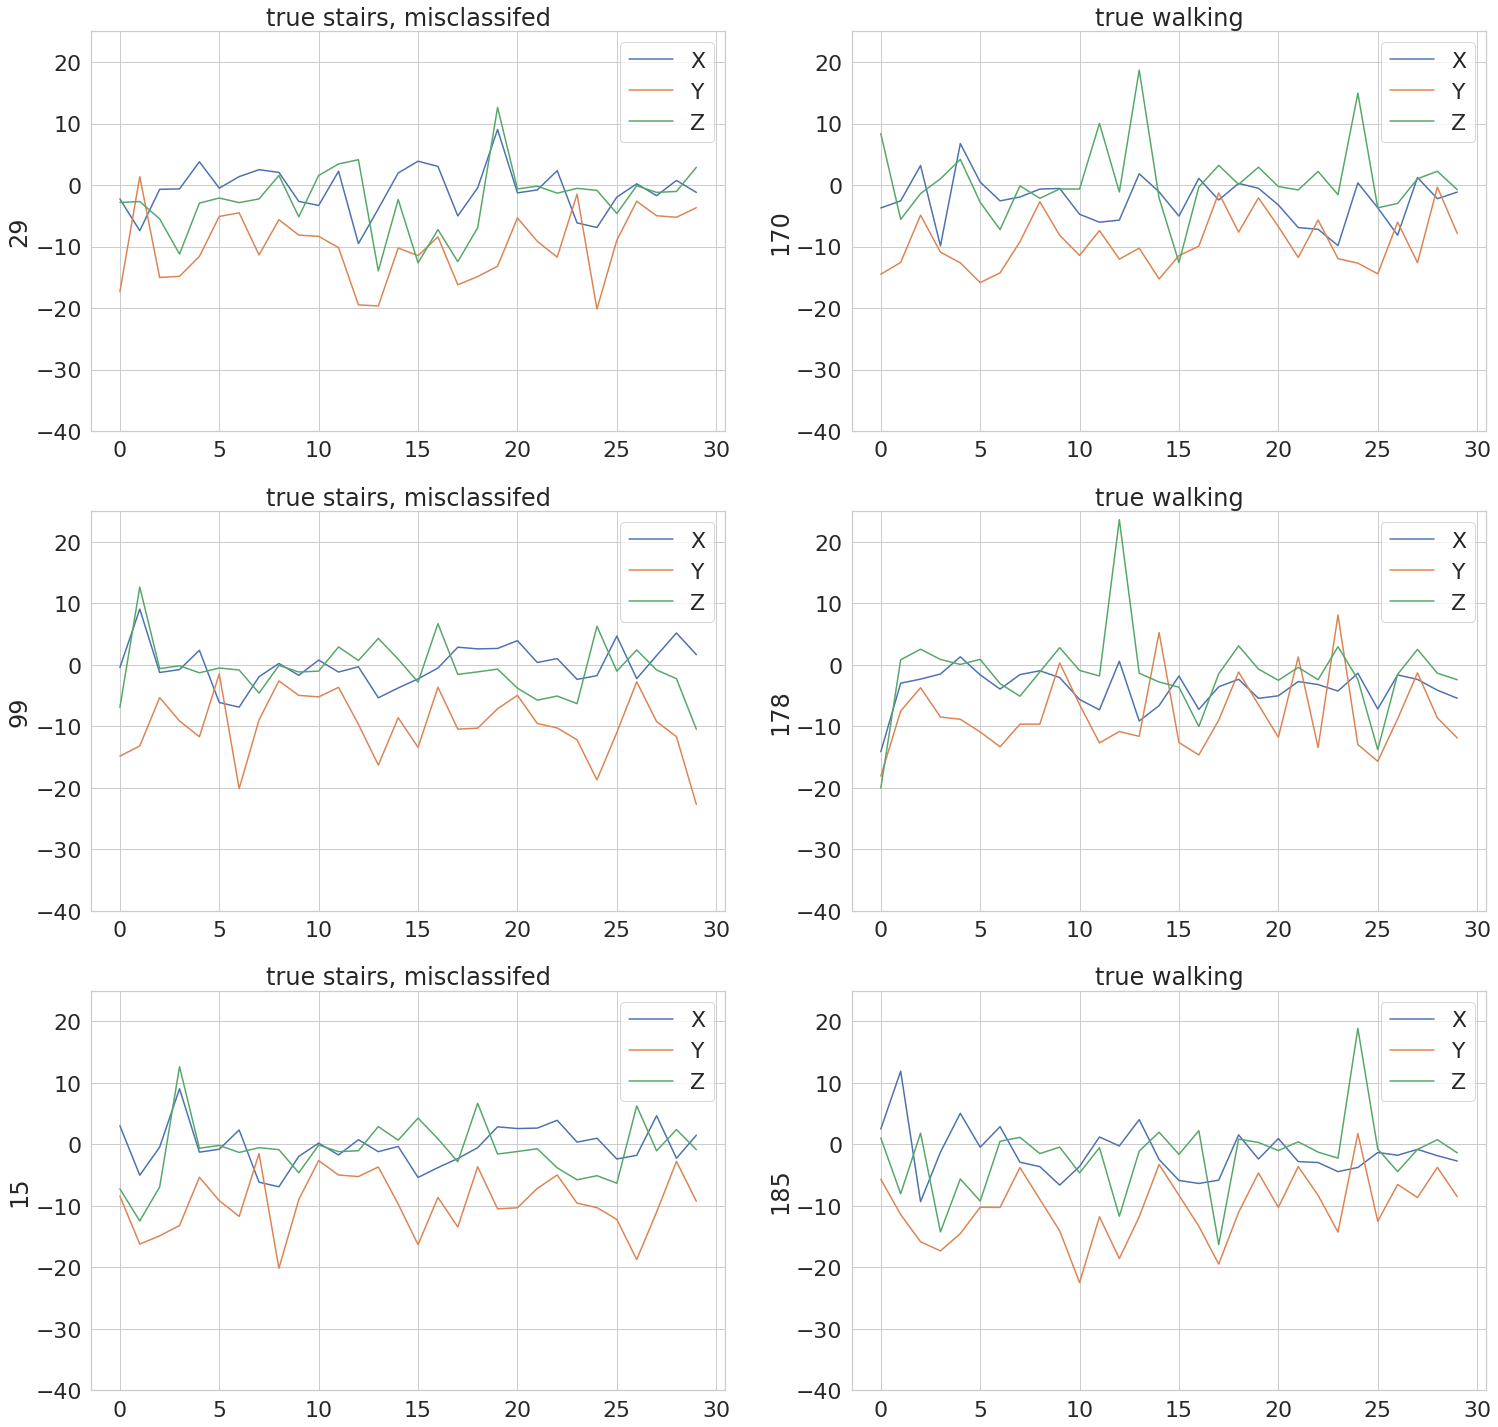

In [460]:
fig, axes = plt.subplots(3, 2, figsize=(25, 25))

misclassified_ix = [29, 99, 15, 89]
for i, ax in enumerate(axes[:, 0]):
    frame = raw_stairs_df.loc[misclassified_ix[i]]
    sns.lineplot(y=frame[x_acc_cols].astype(float), x=np.arange(30), label='X', ax=ax)
    sns.lineplot(y=frame[y_acc_cols].astype(float), x=np.arange(30), label='Y', ax=ax)
    sns.lineplot(y=frame[z_acc_cols].astype(float), x=np.arange(30), label='Z', ax=ax).set_title(f'true {frame.label}, misclassifed')
    ax.set_ylim(-40, 25)
    
true_walking_sample = [170, 178, 185]
for i, ax in enumerate(axes[:, 1]):
    frame = raw_stairs_df.loc[true_walking_sample[i]]
    sns.lineplot(y=frame[x_acc_cols].astype(float), x=np.arange(30), label='X', ax=ax)
    sns.lineplot(y=frame[y_acc_cols].astype(float), x=np.arange(30), label='Y', ax=ax)
    sns.lineplot(y=frame[z_acc_cols].astype(float), x=np.arange(30), label='Z', ax=ax).set_title(f'true {frame.label}')
    ax.set_ylim(-40, 25)

## Average peak frequency

In [482]:
window_size = 10
stride      = 5
n_steps = (FRAME_LENGTH - window_size)//stride + 1

In [483]:
from scipy.signal import find_peaks

In [490]:
def average_peak_frequency(ts):
    n_peaks = []
    for i in range(n_steps):
        left  = i*stride
        right = left + window_size
        peaks, _ = find_peaks(ts[left:right])
        n_peaks.append(len(peaks))

    return np.mean(n_peaks)


In [493]:
stairs_df['apf_x'] = raw_stairs_df[x_acc_cols].apply(average_peak_frequency, axis=1)
stairs_df['apf_y'] = raw_stairs_df[y_acc_cols].apply(average_peak_frequency, axis=1)
stairs_df['apf_z'] = raw_stairs_df[z_acc_cols].apply(average_peak_frequency, axis=1)
stairs_df['apf_m'] = raw_stairs_df[m_acc_cols].apply(average_peak_frequency, axis=1)

apf_features = ['apf_x', 'apf_y', 'apf_z', 'apf_m']

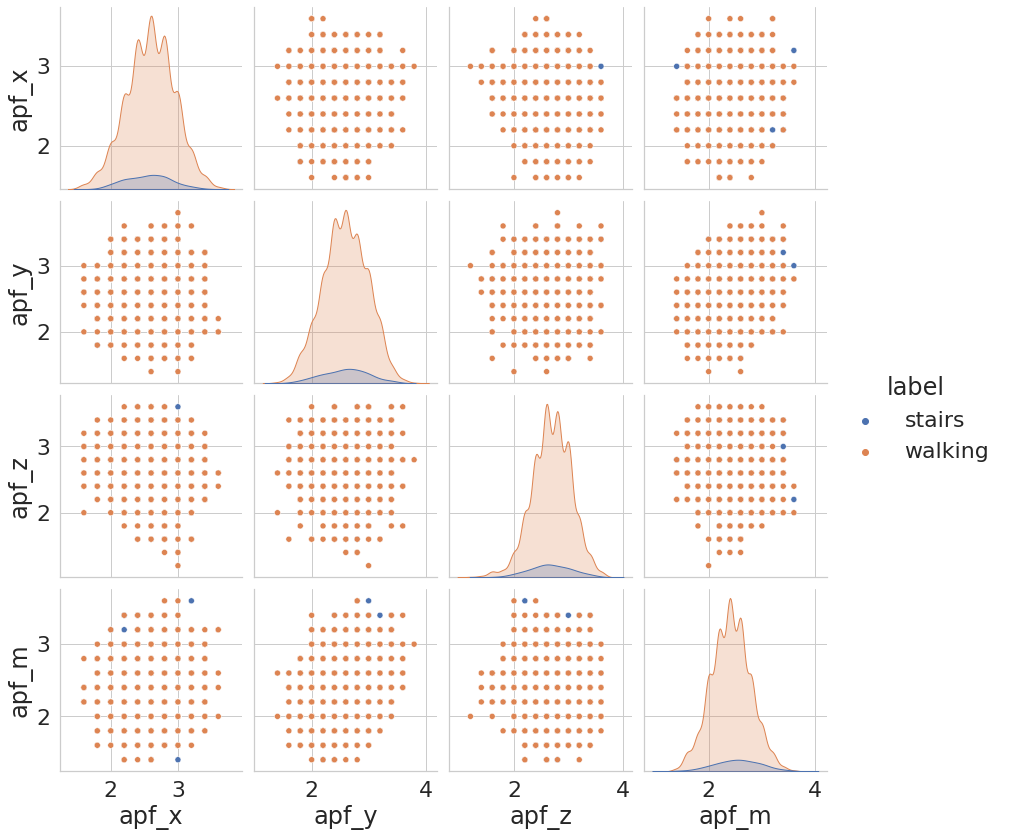

In [495]:
sns.pairplot(data=stairs_df[apf_features + ['label']], hue='label', height=3);

In [500]:
stairs_df['var_apf'] = stairs_df[apf_features].var(axis=1)

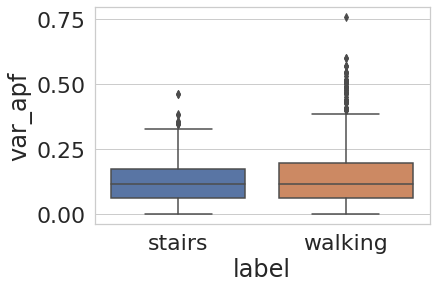

In [501]:
sns.boxplot(data=stairs_df, y='var_apf', x='label')

In [503]:
X = stairs_df[mean_features + minmax_range_features + std_features + rms_features + corr_features + min_features + apf_features + ['var_apf']]
y = stairs_df['is_stairs']
f_scores = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
#     print(valid_ix)
    cls = RandomForestClassifier()
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
#     f_scores.append(f1_score(y_valid, y_pred, average=None).min())
    f_scores.append(f1_score(y_valid, y_pred))
    print(confusion_matrix(y_valid, y_pred))
    print(y_valid[y_valid != y_pred].index)
    
print(f'F1 score mean: {round(np.mean(f_scores), 2)}, std: {round(np.std(f_scores), 2)}')

[[370   0]
 [  2  31]]
Int64Index([29, 99], dtype='int64')
[[370   0]
 [  1  32]]
Int64Index([0], dtype='int64')
[[370   0]
 [  1  32]]
Int64Index([78], dtype='int64')
[[370   0]
 [  2  31]]
Int64Index([15, 89], dtype='int64')
[[370   0]
 [  2  31]]
Int64Index([4, 149], dtype='int64')
F1 score mean: 0.98, std: 0.01


In [335]:
len(mean_features + minmax_range_features + std_features + rms_features + corr_features)

15

In [363]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier


In [430]:
X = stairs_df[mean_features + minmax_range_features + std_features + rms_features + corr_features]
y = stairs_df['is_stairs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

cls = DecisionTreeClassifier()
cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)
print(f1_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.8571428571428572
[[557   8]
 [  4  36]]


In [364]:
feature_names = mean_features + minmax_range_features + std_features + rms_features + corr_features
class_names=['walking', 'stairs']

In [366]:
!pip install graphviz

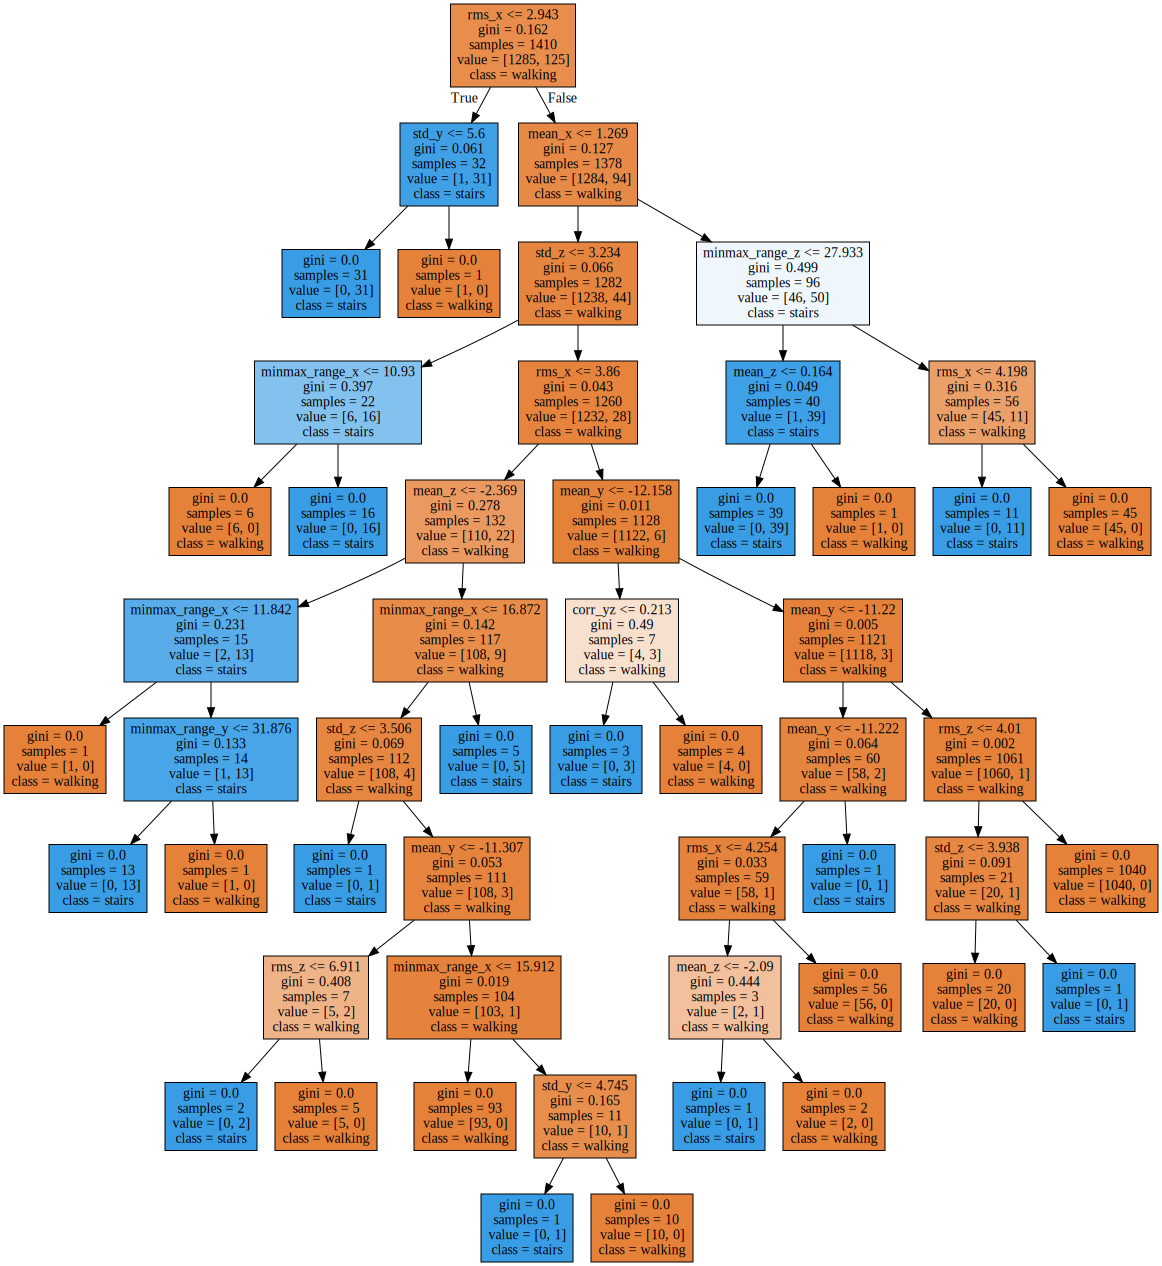

In [369]:
import graphviz
# DOT data
dot_data = export_graphviz(cls, out_file=None, 
                                feature_names=feature_names,  
                                class_names=class_names,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

## Am - magnitude of acceleration

acc_z_0    acc_z_1    acc_z_2    acc_z_3    acc_z_4    acc_z_5  \
0     11.927636   3.127652  11.653101   1.388984   6.800185   6.163397   
1     11.201113  13.668571   8.669187  13.750462  16.333431  13.727206   
2      8.575325   8.843720  12.769168  22.054542  15.497260  18.800717   
3      9.481083  10.736675  16.220835  16.395978   5.594716   6.643176   
4     23.088918  27.482133  17.723770   8.011505  16.021161  18.624341   
...         ...        ...        ...        ...        ...        ...   
2010   7.347210  10.200123  22.742465  14.182402  12.094765  15.186279   
2011   1.803195   7.797046   4.886971   9.018421  17.074183   8.750563   
2012  15.996356  10.584957  17.326156  34.663587  14.091223  37.076429   
2013   4.811223   9.004177  17.515290  20.406268  15.754896  19.203144   
2014  16.504408  33.435081  12.997781  23.430716  12.443488   4.404316   

        acc_z_6    acc_z_7    acc_z_8    acc_z_9  ...   acc_z_20   acc_z_21  \
0      6.324640  14.465774   9.021730  16.684983  ...  14.010827  22.597199   
1      8.254059  29.605543   7.527753   8.023869  ...   4.342221   6.940678   
2     17.148607   9.568494  13.057860  27.486417  ...  26.422006  10.926848   
3      5.393838  10.046695  14.249183   6.959825  ...   5.899900  11.440210   
4     12.548157   5.547264   5.523368  11.854716  ...  16.424568  20.377769   
...         ...        ...        ...        ...  ...        ...        ...   
2010  24.023262  14.205715  33.834211  10.061538  ...  12.654519   3.097572   
2011  13.423270  26.173042  11.897453   4.465732  ...   2.910707   7.769113   
2012   6.854446   6.447129  14.148808   5.730225  ...  20.847240  12.880346   
2013  13.277872   4.520968   7.281417   9.962341  ...  17.712494  26.830176   
2014  10.082763  19.584407  19.593527  12.920186  ...   9.285361  14.540813   

       acc_z_22   acc_z_23   acc_z_24   acc_z_25   acc_z_26   acc_z_27  \
0     14.597832   3.849918   8.267060   6.248105   9.497119  14.720401   
1      8.543656  10.177108   9.888059   7.962330   9.761773   6.102111   
2      4.351333  12.223536  10.364066   8.323148   5.912421   6.941231   
3     15.197645   7.338438  19.238624  12.173098  17.799367  13.982543   
4      5.540156   9.196438  12.025496   6.358463  21.326532  10.287895   
...         ...        ...        ...        ...        ...        ...   
2010   8.035324  11.151147  15.044943  20.695188  14.892159  11.477036   
2011   6.747545  12.544318  19.225936  28.865273  11.296899  10.291225   
2012  14.618540  13.616351  12.470924  15.362039  12.028276   5.914983   
2013  11.738785   5.631035   7.988237  10.689546  17.160942  14.226730   
2014  19.562630  14.261362  24.485585   8.629582   4.941113  13.857389   

       acc_z_28   acc_z_29  
0     11.890416   8.611713  
1      9.302489   5.768746  
2      7.138964   9.721466  
3     11.569348   6.247109  
4      2.652970   5.417821  
...         ...        ...  
2010  19.585552  16.249177  
2011  12.262146   1.478950  
2012   8.207181   9.948428  
2013  17.225293  13.951249  
2014  12.685312  17.718753  

[2015 rows x 30 columns]

## n peaks

In [461]:
from scipy.signal import find_peaks

In [462]:
def count_peask(ts):
    peaks, _ = find_peaks(ts)
    return len(peaks)


In [463]:
count_peask(raw_data[x_acc_cols].iloc[0])

11

In [214]:
feature_df['n_peaks'] = raw_data[x_acc_cols].apply(count_peask, axis=1)

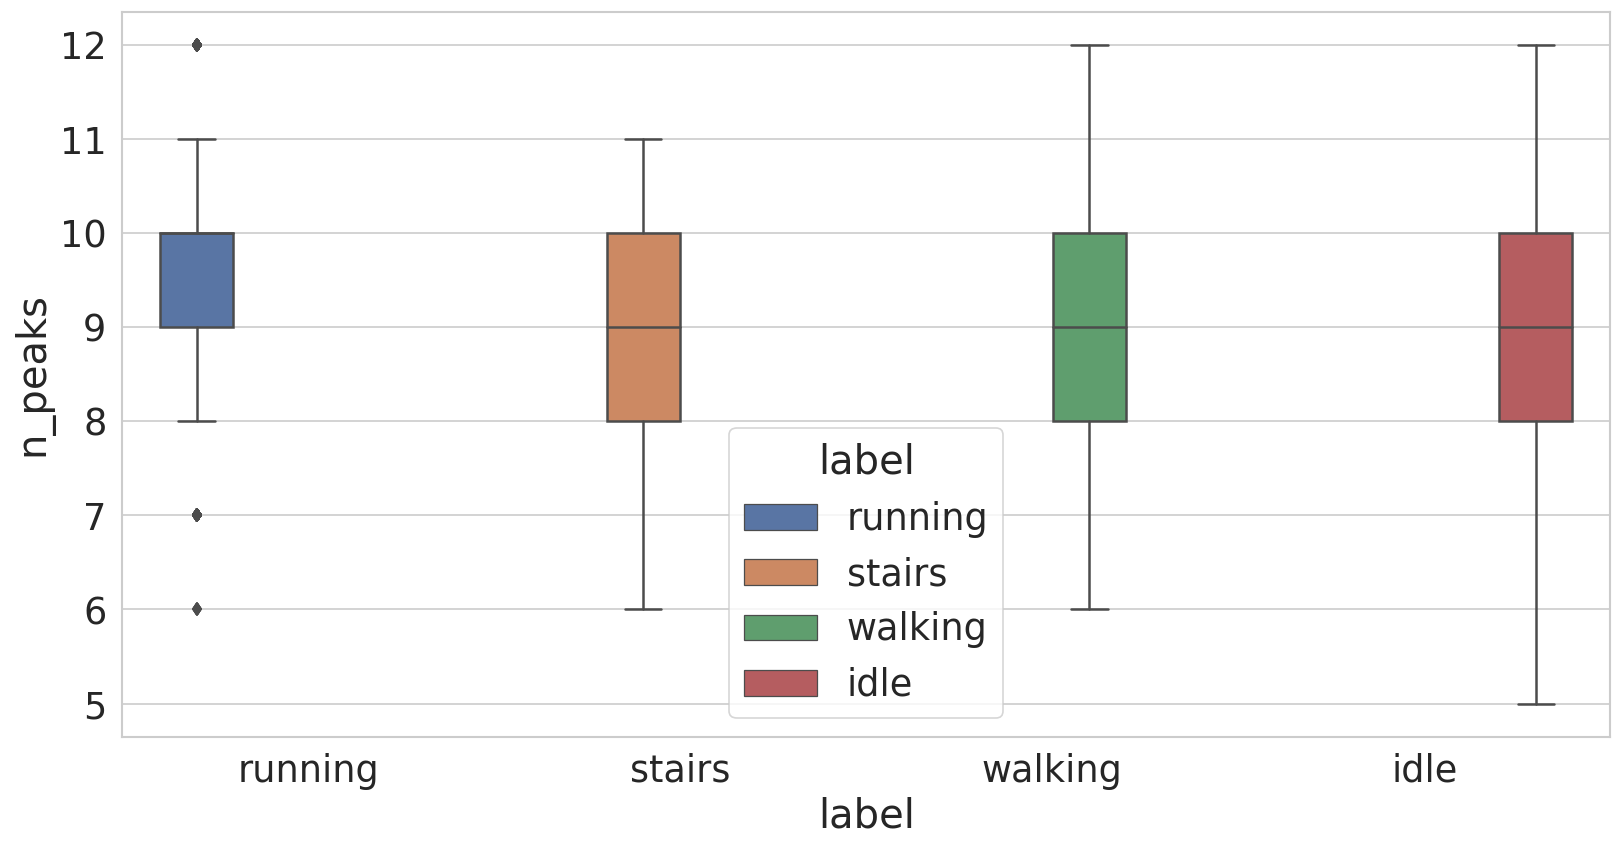

In [216]:
sns.boxplot(data=feature_df, x='label', y='n_peaks', hue="label",)

List of features:

1. Mean on every axis
2. average of peak frequency